# Regression spotting project

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection
from matplotlib import pyplot as plt
plt.style.use('dark_background')

from sklearn.preprocessing import StandardScaler
import umap.plot


/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

In [2]:
# Paths:
input_dir = Path.cwd() / "../input_data"
plots_dir = Path.cwd() / "../plots"
plots_dir.mkdir(exist_ok=True)
result_dir = Path.cwd() / "../results/multioutput"
result_dir.mkdir(exist_ok=True, parents=True)

## Loading data
Loading fingerprints, and molecule properties


In [3]:
# Load fingerprints:
fingerprints = pd.read_csv(input_dir / "fingerprints.csv", index_col=0)
fingerprints.sort_index(inplace=True)
# There seems to be some duplicates in the rows:
fingerprints.drop_duplicates(inplace=True)
# Save columns names:
fingerprints_cols = fingerprints.columns

fingerprints
# fingerprints.addu

,1,8,13,26,27,31,35,41,45,62,...,1977,1991,1992,1995,2001,2004,2018,2034,2038,2044
mol_name,,,,,,,,,,,,,,,,,,,,,
2-Oxoglutaric acid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Hydroxyanthranilic acid,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3-Hydroxymethylglutaric acid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Phosphoglyceric acid,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"4,5-Dihydroorotic acid",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
alpha-tocopherol,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cis-Aconitic acid,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Load properties:
mol_properties = pd.read_csv(input_dir / "physchem_properties.csv", index_col=0)
mol_properties.sort_index(inplace=True)
mol_properties.drop_duplicates(inplace=True)
# mol_properties.set_index("name_short", inplace=True)
mol_properties_cols = mol_properties.columns
mol_properties

,pka_strongest_acidic,pka_strongest_basic,polar_surface_area,polarizability,acceptor_count,donor_count,physiological_charge
name_short,,,,,,,
2-Oxoglutaric acid,2.66,-9.70,91.67,12.17,5.0,2.0,-2.0
3-Hydroxyanthranilic acid,1.94,4.82,83.55,14.18,4.0,3.0,-1.0
3-Hydroxymethylglutaric acid,3.68,-3.00,94.83,14.55,5.0,3.0,-2.0
3-Phosphoglyceric acid,1.30,-4.20,124.29,13.29,6.0,4.0,-3.0
"4,5-Dihydroorotic acid",3.28,-8.20,95.50,13.09,4.0,3.0,-1.0
...,...,...,...,...,...,...,...
Xanthine,7.95,-0.70,86.88,12.70,3.0,3.0,0.0
alpha-tocopherol,10.80,-4.90,29.46,55.29,2.0,1.0,0.0
cis-Aconitic acid,2.11,NaN,111.90,14.16,6.0,3.0,-3.0


Check statistics of molecular properties and handle NaN values:


/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_5841/1539120124.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  mol_properties.hist(ax=ax)


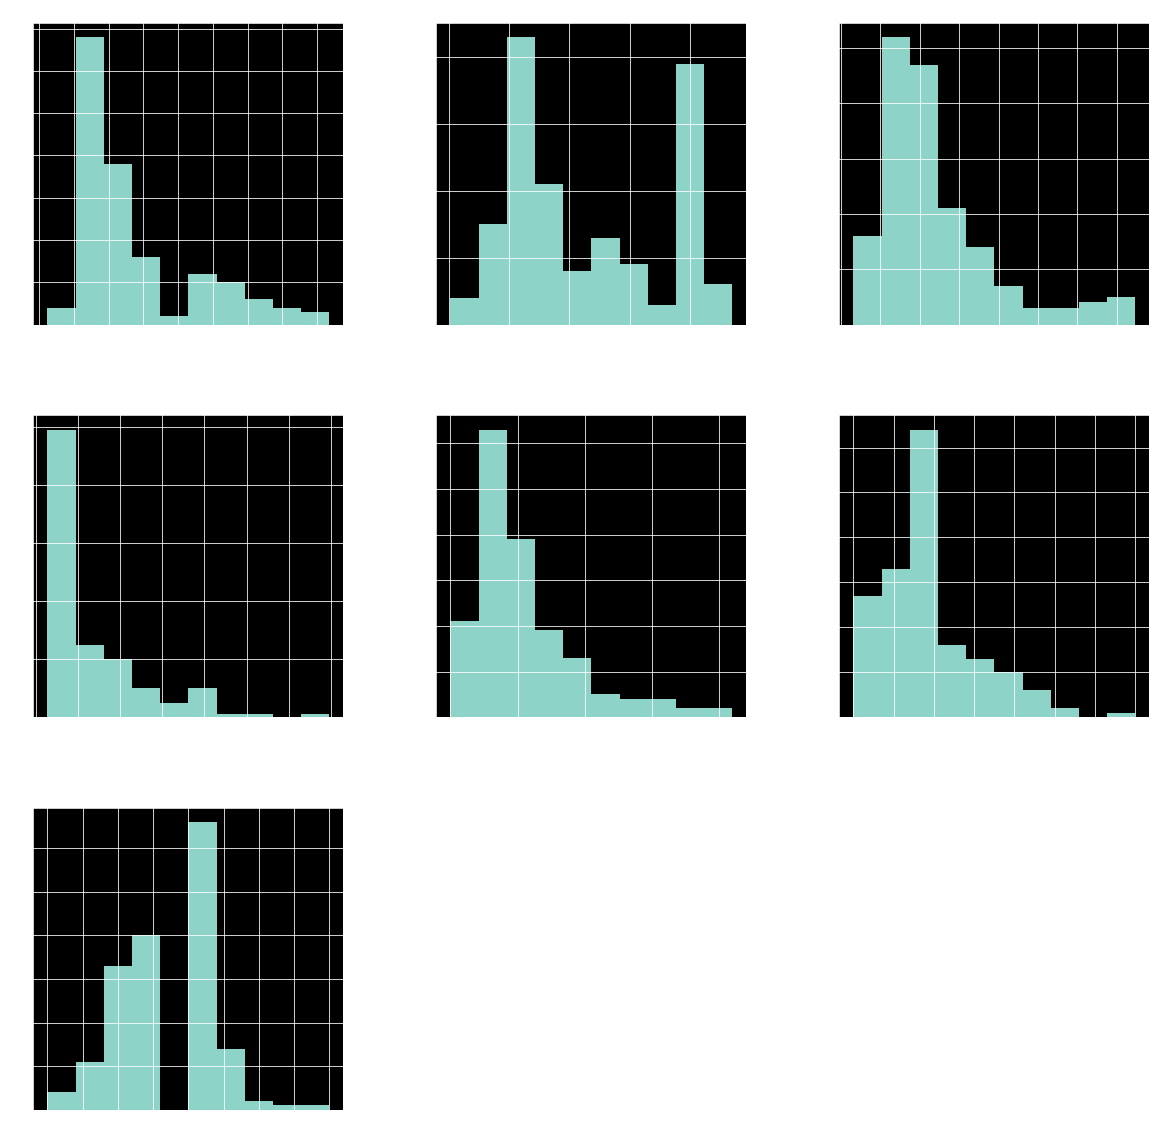

In [5]:
# Plot histograms:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
mol_properties.hist(ax=ax)
fig.savefig(plots_dir / "mol_features.pdf")

In [6]:
# Check for NaN values:
is_null = mol_properties.isnull()
for col in mol_properties_cols:
    print("---")
    print(is_null[col].value_counts())

# FIXME: temporarely set NaN to zero
mol_properties[is_null] = 0.

---
False    163
True       9
Name: pka_strongest_acidic, dtype: int64
---
False    161
True      11
Name: pka_strongest_basic, dtype: int64
---
False    172
Name: polar_surface_area, dtype: int64
---
False    172
Name: polarizability, dtype: int64
---
False    172
Name: acceptor_count, dtype: int64
---
False    172
Name: donor_count, dtype: int64
---
False    172
Name: physiological_charge, dtype: int64


In [7]:
# Perform some basic checks:
assert fingerprints.index.is_unique
assert mol_properties.index.is_unique

In [8]:
print("Number of fingerprints: ", len(fingerprints))
print("Number of mol properties: ", len(mol_properties))

print("Molecules with missing fingerprints: ")
missing_molecules = list(mol_properties[~ mol_properties.index.isin(fingerprints.index)].index)
print(missing_molecules)

# min(fingerprints.iloc[3, ] == fingerprints.iloc[4, ])


Number of fingerprints:  169
Number of mol properties:  172
Molecules with missing fingerprints: 
['Adenosine triphosphate', 'Ribose 5-phosphate', 'Spermine']


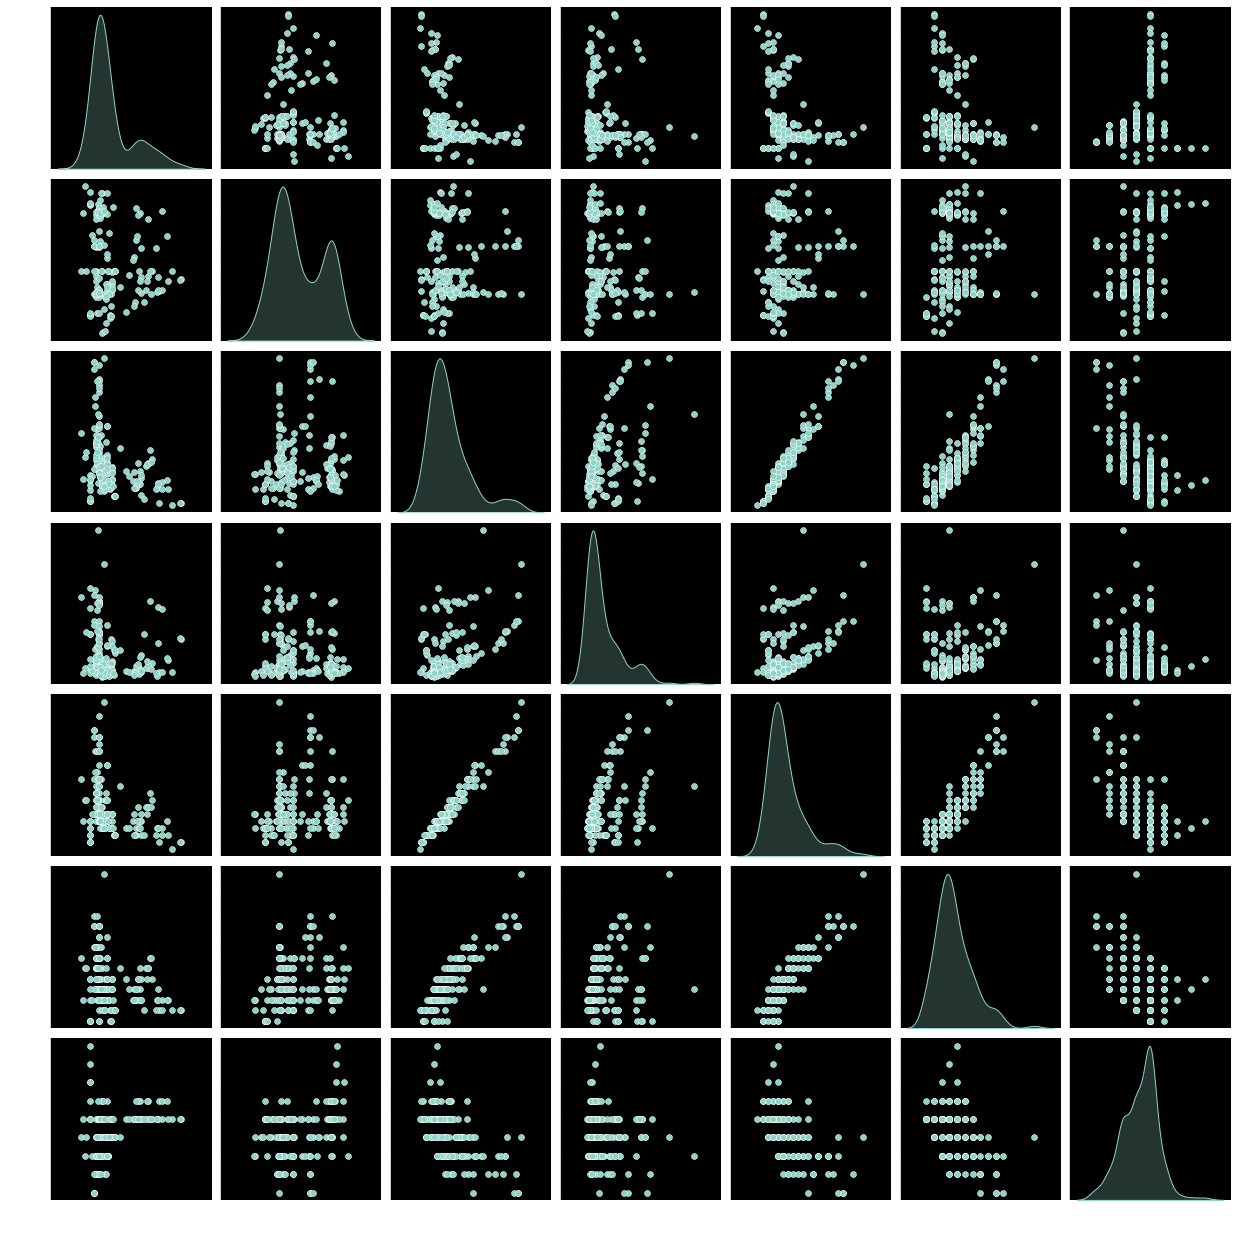

In [9]:
sns.pairplot(data=mol_properties, diag_kind='kde')

Merge fingerprints and properties:

In [10]:
all_mol_features = pd.merge(mol_properties, fingerprints, how="inner", right_index=True, left_index=True)
all_mol_features


,pka_strongest_acidic,pka_strongest_basic,polar_surface_area,polarizability,acceptor_count,donor_count,physiological_charge,1,8,13,...,1977,1991,1992,1995,2001,2004,2018,2034,2038,2044
2-Oxoglutaric acid,2.66,-9.70,91.67,12.17,5.0,2.0,-2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Hydroxyanthranilic acid,1.94,4.82,83.55,14.18,4.0,3.0,-1.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3-Hydroxymethylglutaric acid,3.68,-3.00,94.83,14.55,5.0,3.0,-2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3-Phosphoglyceric acid,1.30,-4.20,124.29,13.29,6.0,4.0,-3.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"4,5-Dihydroorotic acid",3.28,-8.20,95.50,13.09,4.0,3.0,-1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthine,7.95,-0.70,86.88,12.70,3.0,3.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
alpha-tocopherol,10.80,-4.90,29.46,55.29,2.0,1.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
cis-Aconitic acid,2.11,0.00,111.90,14.16,6.0,3.0,-3.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
gamma-Aminobutyric acid,4.53,10.22,63.32,10.62,3.0,2.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Loading intensities

In [11]:
# Intensities:
intensities = pd.read_csv(input_dir / "3june22_ions_no_nl.csv", index_col=0)
intensities = intensities.rename(columns={"Matrix short": "matrix", "Polarity": "polarity"})
intensities.head()

# Set intensities below 100 to zero:
intensities.loc[intensities["spot_intensity"] < 100,"spot_intensity"] = 0
intensities.loc[intensities["spot_intensity"] < 100,"detected"] = 0

In [12]:
# Sanity checks:
nb_before = len(intensities.name_short.unique())

# Delete molecules with missing properties:
intensities = intensities[~intensities.name_short.isin(missing_molecules)]
print("{}/{} molecules kept".format(len(intensities.name_short.unique()), nb_before))



169/172 molecules kept


#### (Optionally) Remove molecule-adduct combinations that were never observed in any matrix

In [13]:
remove_not_detected_adducts = False

if remove_not_detected_adducts:
    g = intensities.groupby(["name_short", "adduct"], as_index=False)["detected"].max()
    nb_comb_before = intensities.shape[0]
    intensities = intensities.merge(g[g["detected"] == 1][["name_short", "adduct"]])
    print("{}/{} combinations of molecules/adduct with non-zero observed values".format(intensities.shape[0], nb_comb_before))

    # Now check if some molecules are never observed (for any adduct) and
    # remove them from the feature vectors:
    nb_mol_before = len(all_mol_features.index)
    all_mol_features = all_mol_features[all_mol_features.index.isin(intensities["name_short"].unique())]
    print("{}/{} molecules with non-zero observed values".format(len(all_mol_features.index), nb_mol_before))

#### How many molecules-adduct observed per matrix-polarity


In [14]:
g = intensities.groupby(['matrix', 'polarity'], as_index=False)
detected_ratio = g["detected"].apply(lambda x: x.sum() / x.shape[0])
detected_ratio["Sum detected"] = g["detected"].sum()["detected"]

# Show values:
detected_ratio.sort_values("detected", ascending=False).rename(columns={"detected": "Ratio detected molecules"})

,matrix,polarity,Ratio detected molecules,Sum detected
13,DHB,positive,0.290786,344
3,CHCA,positive,0.266272,315
7,ClCCA,positive,0.240068,284
19,pNA,positive,0.197802,234
5,CMBT,positive,0.178360,211
11,DHAP,positive,0.165680,196
9,DAN,positive,0.148774,176
0,9AA,negative,0.127642,151
8,DAN,negative,0.115807,137
16,NOR,negative,0.114117,135


Get statistics about adducts:


/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_5841/4048890389.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  std_intesities.hist(column=["detected"], by=['matrix', "polarity"], grid=False, ax=ax)


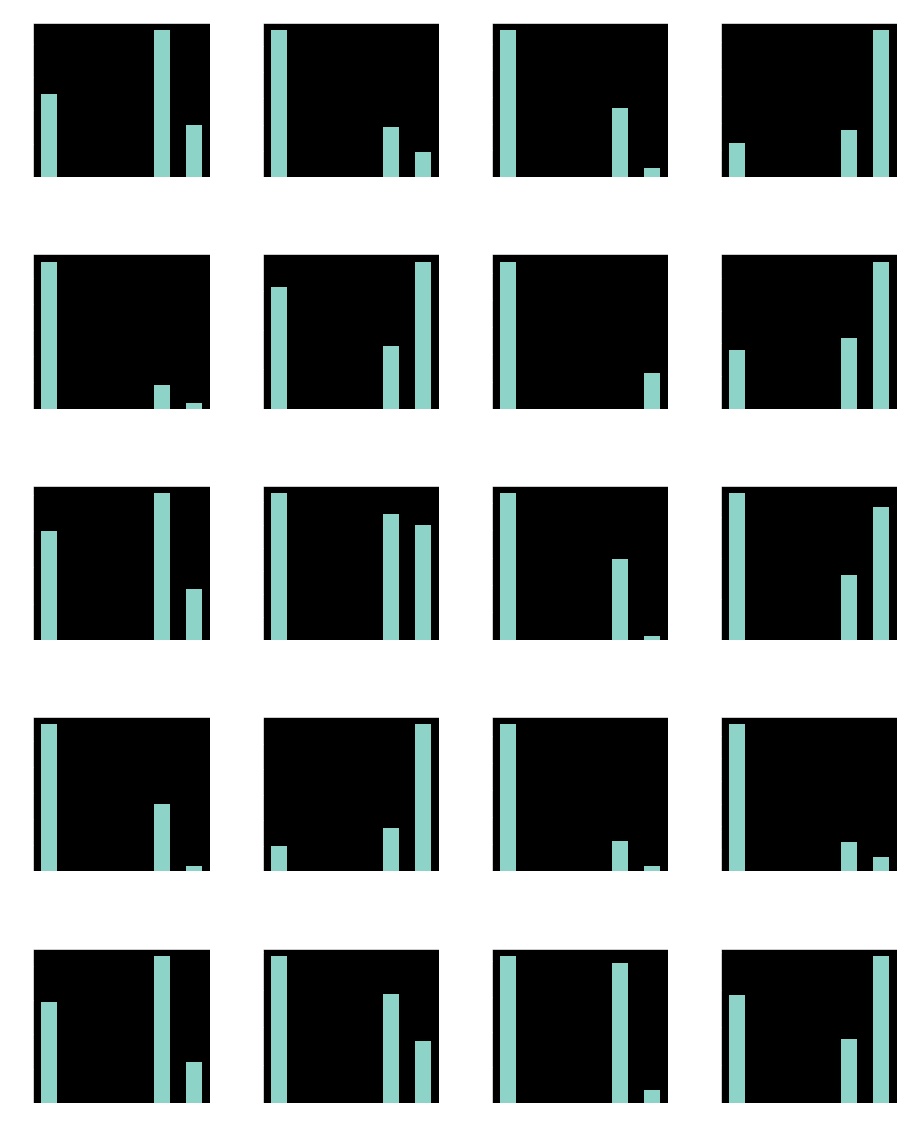

In [15]:
std_intesities = intensities.groupby(['matrix', "polarity", "name_short"], as_index=False).std()

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
std_intesities.hist(column=["detected"], by=['matrix', "polarity"], grid=False, ax=ax)
fig.savefig(plots_dir / "std_detected_value.pdf")



In [16]:
# Check if entries with std=0 are always not detected:
std_intesities[std_intesities["detected"] == 0]["spot_intensity"].value_counts()

0.0    1651
Name: spot_intensity, dtype: int64

**Conclusion**: Intensities always vary across adducts (in histograms, std=0 entries were never detected for any adducts)

In [17]:
# Convert adducts to one-hot encoding:
adducts_one_hot = pd.get_dummies(intensities.adduct, prefix='adduct')
adducts_columns = adducts_one_hot.columns
intensities = intensities.merge(right=adducts_one_hot, right_index=True, left_index=True)

### How many matrices with non-zero values per molecule+adduct
Many adducts occure in several matrices, but let's see how intensities look like, ranked by higher to lower:

In [18]:
g = intensities.sort_values("spot_intensity", ascending=False).groupby(["name_short", "adduct"], as_index=False)
intensity_stats = g["detected"].sum()
for matrix_index in range(20):
    # intensity_stats["matrix_{}".format(matrix_index)] = g["spot_intensity"].max()["spot_intensity"]
    intensity_stats["matrix_{}".format(matrix_index)] = g["spot_intensity"].apply(lambda x: x.iloc[matrix_index])["spot_intensity"]
# assert intensity_stats["max"].equals(intensity_stats["max2"])
intensity_stats



,name_short,adduct,detected,matrix_0,matrix_1,matrix_2,matrix_3,matrix_4,matrix_5,matrix_6,...,matrix_10,matrix_11,matrix_12,matrix_13,matrix_14,matrix_15,matrix_16,matrix_17,matrix_18,matrix_19
0,2-Oxoglutaric acid,+Cl,0,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2-Oxoglutaric acid,+H,0,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2-Oxoglutaric acid,+K,0,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2-Oxoglutaric acid,+Na,1,210.54546,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2-Oxoglutaric acid,-H,8,65207.86300,36786.18400,6752.45900,6166.86670,1492.5983,1489.3842,930.48126,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,myo-Inositol,+K,1,509.49255,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1179,myo-Inositol,+Na,8,4049.50300,1613.17870,1452.60740,1354.67750,772.0206,648.3625,535.32074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1180,myo-Inositol,-H,4,1942.04330,455.85037,318.54172,130.82251,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1181,myo-Inositol,[M]+,0,0.00000,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

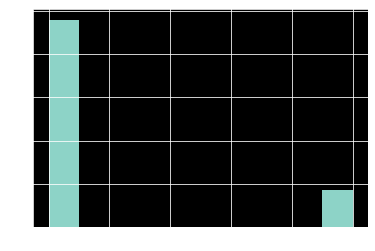

In [19]:
sorted_intensities = intensities.sort_values(by=['name_short', 'adduct',  "matrix", "polarity"])

g = sorted_intensities.groupby(by=['name_short', 'adduct'])
intesity_matrix = np.array([rows.to_numpy() for _, rows in g["spot_intensity"]])
matrix_names = sorted_intensities[["matrix", "polarity"]].drop_duplicates()
matrix_names["combined"] = matrix_names.applymap(str).apply('-'.join, axis=1)
# matrix_names
intesity_matrix = pd.DataFrame(intesity_matrix, columns=matrix_names["combined"])
intesity_matrix = intesity_matrix > 100
intesity_matrix.value_counts()[60:].hist()

# intesity_matrix.merge(sorted_intensities[['name_short', 'adduct']].drop_duplicates().reset_index(drop=True), left_index=True, right_index=True)



#### Intensity histograms across matrices (before normalization)
Only plot intensities > 100:

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_5841/174860316.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = intensities[intensities["spot_intensity"] > 100.].hist("spot_intensity", by=["matrix", "polarity"], ax=ax, sharex=True)


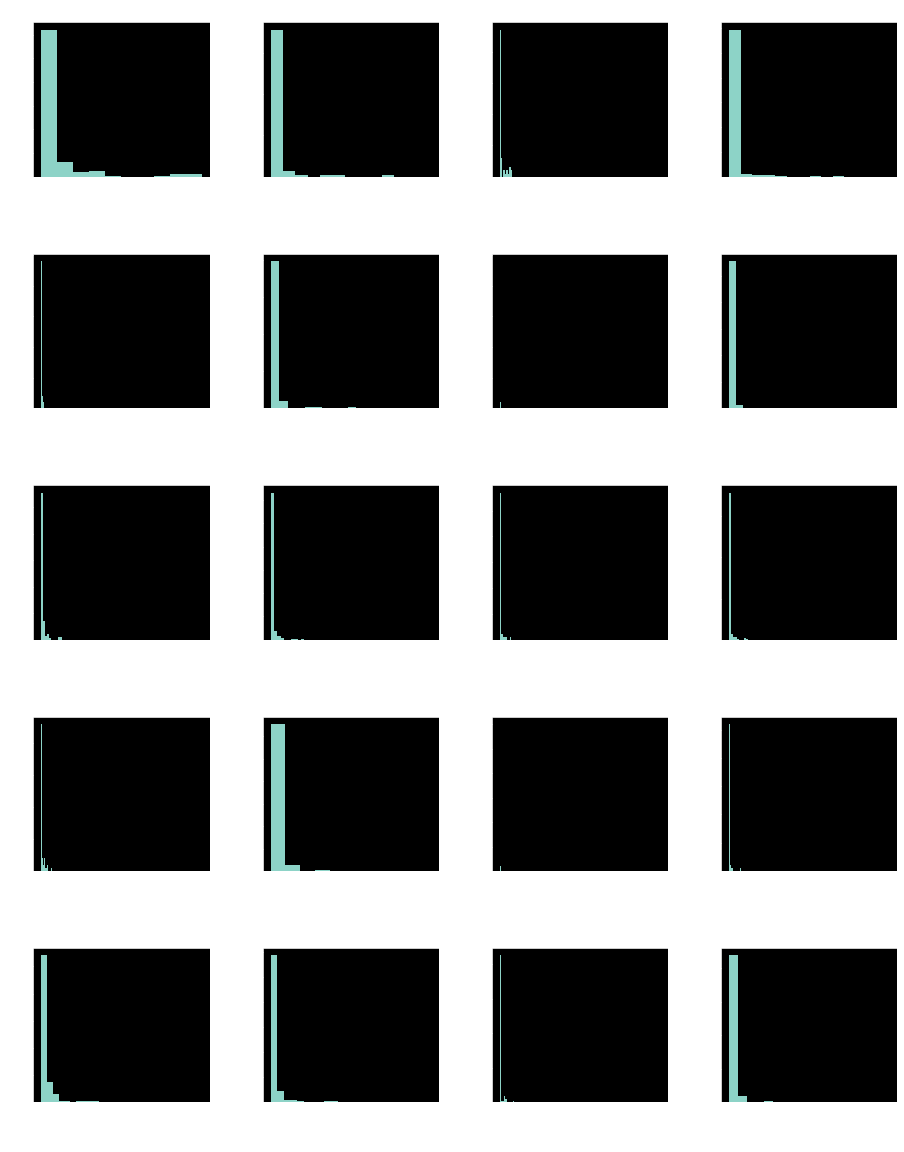

In [20]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()


_ = intensities[intensities["spot_intensity"] > 100.].hist("spot_intensity", by=["matrix", "polarity"], ax=ax, sharex=True)

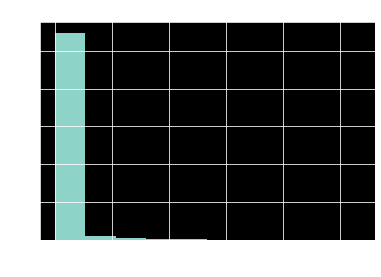

In [21]:
_ = intensities[intensities["spot_intensity"] > 100].hist("spot_intensity")

## Methods for standartization/normalization
First, normalize features

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer


ss = StandardScaler()
pt = PowerTransformer()

#OPTION 1
features_norm_df = pd.DataFrame(pt.fit_transform(all_mol_features),
                                index = all_mol_features.index,
                                columns = all_mol_features.columns)

# OPTION 2
#features_norm_df = pd.DataFrame(ss.fit_transform(all_mol_features), index = all_mol_features.index, columns = all_mol_features.columns)

# OPTION 3 (Seurat normalization)
#features_norm_df = np.log2((all_mol_features.T / all_mol_features.T.sum().values) * 10000 + 1).T


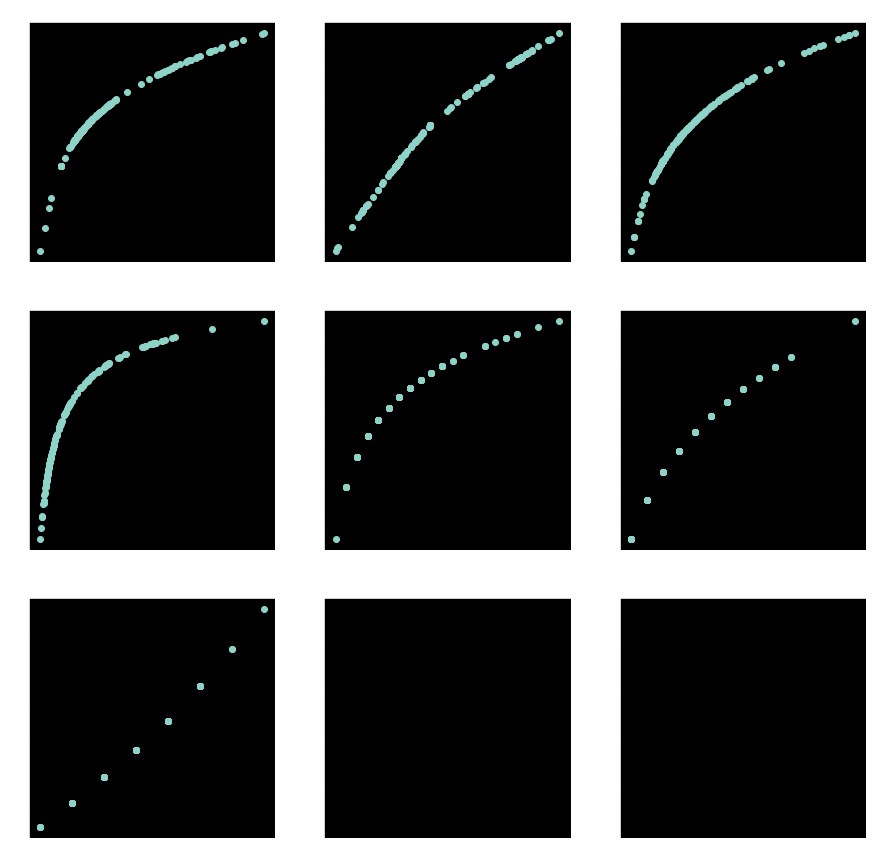

In [23]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = [axes[i,j] for i in range(num_cols) for j in range(num_rows)]
for i, ax in enumerate(axes):
    if i < len(mol_properties_cols):
        sc = ax.scatter(all_mol_features[mol_properties_cols[i]], features_norm_df[mol_properties_cols[i]],
               # cmap = plt.cm.SOME_CM
               )
        # plt.colorbar(sc, ax=ax)
        ax.set_title(mol_properties_cols[i])
    # ax.axis('off')


#### Intensities normalization

In [24]:
# intensities[intensities["spot_intensity"] < 100]["spot_intensity"] = 0

# V1 normalization:
intensities["norm_intensity"] = pt.fit_transform(intensities[["spot_intensity"]])

# V2:
numpy_intensities = intensities[["spot_intensity"]].to_numpy()
intensities["norm_intensity_seurat"] = np.log2((numpy_intensities.T / numpy_intensities.T.sum()) * 10000 + 1).T

In [25]:
# intensities[intensities["spot_intensity"] < 100]["spot_intensity"] = 0
intensities.groupby(['matrix', 'polarity'], as_index=False)["spot_intensity"].apply(lambda x: (x>100).sum()).sort_values("spot_intensity")


,matrix,polarity,spot_intensity
4,CMBT,negative,33
6,ClCCA,negative,33
14,NEDC,negative,39
15,NEDC,positive,56
12,DHB,negative,60
10,DHAP,negative,65
2,CHCA,negative,66
1,9AA,positive,78
18,pNA,negative,94
17,NOR,positive,133


Histograms for normalization_v1: zeros values are mapped to negative values. Everything that originally had intensity < 100 is not plotted

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_5841/3936028774.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity", by=["matrix", "polarity"], ax=ax, sharex=True)


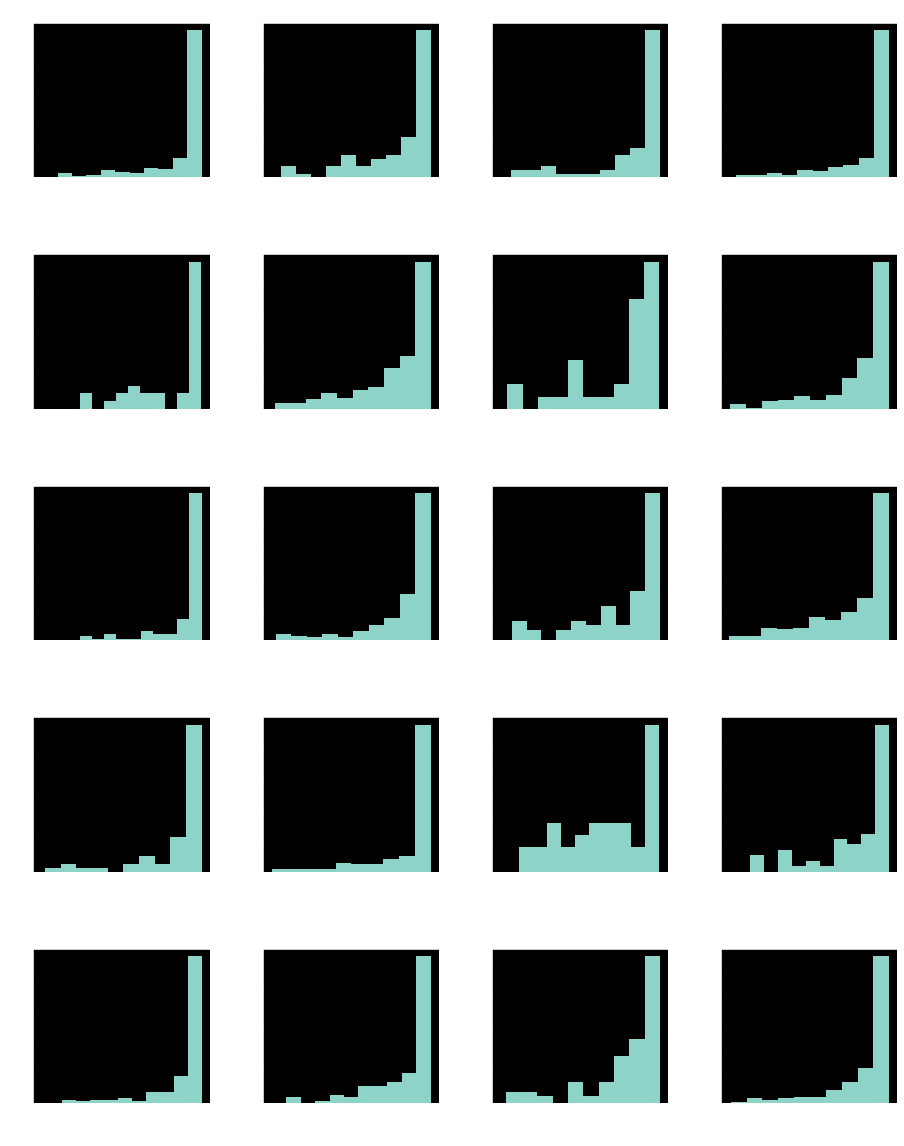

In [26]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()


_ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity", by=["matrix", "polarity"], ax=ax, sharex=True)

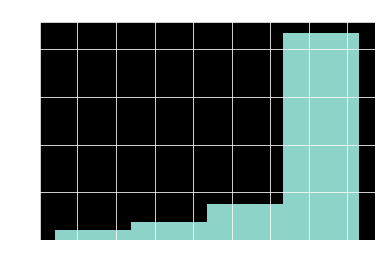

In [27]:
_ = intensities[intensities["norm_intensity"] > 0].hist("norm_intensity", bins=4)

Histograms for Seurat normalization:

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_5841/2462799206.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  _ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity_seurat", by=["matrix", "polarity"], ax=ax, sharex=True, sharey=True)


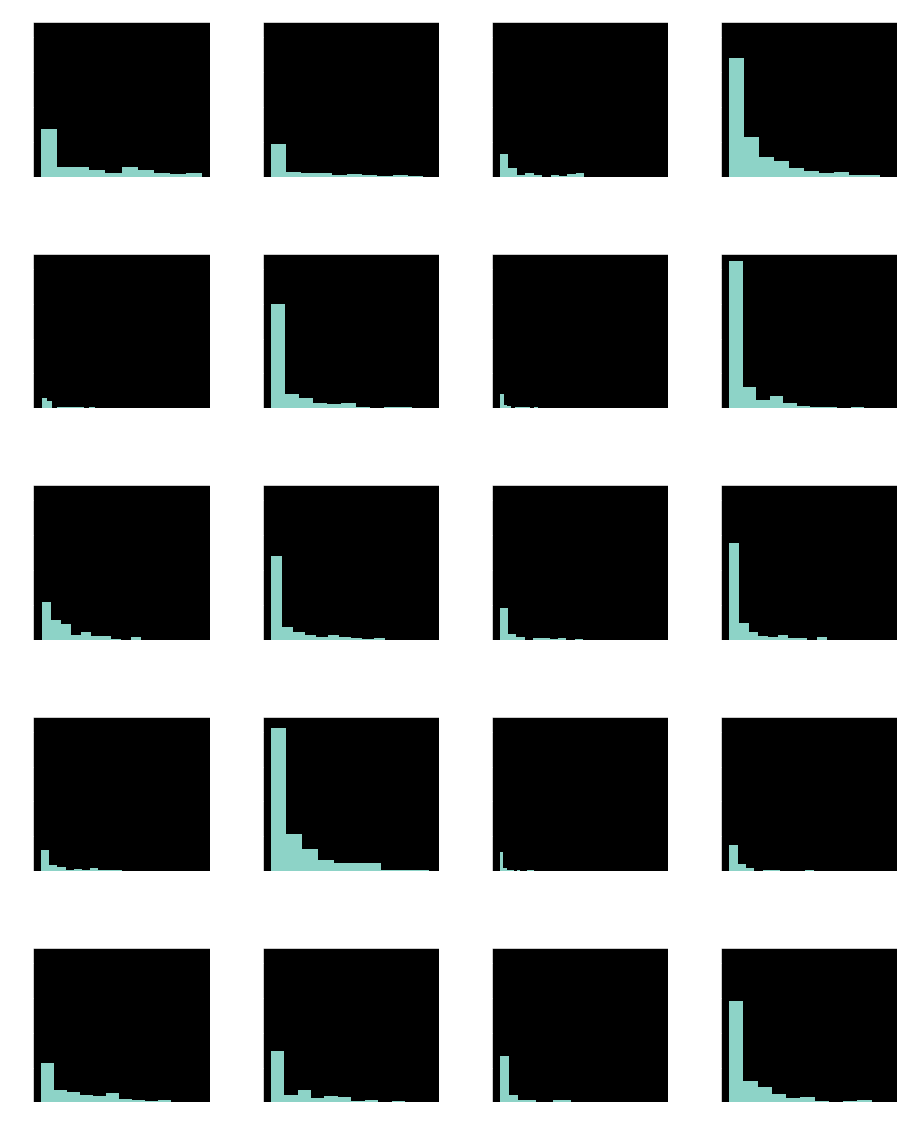

In [28]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()


_ = intensities[intensities["spot_intensity"] > 100].hist("norm_intensity_seurat", by=["matrix", "polarity"], ax=ax, sharex=True, sharey=True)

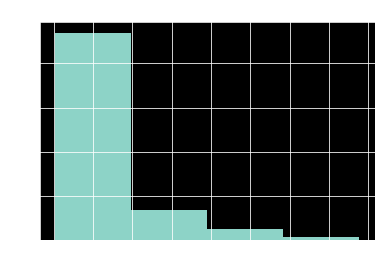

In [29]:
_ = intensities[intensities["norm_intensity_seurat"] > 0].hist("norm_intensity_seurat", bins=4)


Check how many times a matrix is the "top" matrix:

In [30]:
g = intensities.sort_values("norm_intensity_seurat", ascending=False).groupby(["name_short", "adduct"], as_index=False)
intensity_stats = g["detected"].sum()
# g.apply(lambda x: x.iloc[0])["matrix"]
intensity_stats["top_matrix"] = g.apply(lambda x: x.iloc[0])["matrix"]
intensity_stats["top_polarity"] = g.apply(lambda x: x.iloc[0])["polarity"]
for matrix_index in range(20):
    # intensity_stats["matrix_{}".format(matrix_index)] = g["norm_intensity_seurat"].max()["norm_intensity_seurat"]
    intensity_stats["matrix_{}".format(matrix_index)] = g["norm_intensity_seurat"].apply(lambda x: x.iloc[matrix_index])["norm_intensity_seurat"]
# assert intensity_stats["max"].equals(intensity_stats["max2"])
# intensity_stats


In [31]:
# Ignore never-detected ions:
intensity_stats[intensity_stats["matrix_0"] > 0][["top_matrix", "top_polarity"]].value_counts()
# pd.DataFrame().hist()


top_matrix  top_polarity
DHB         positive        162
CHCA        positive        162
9AA         negative         96
DAN         negative         50
pNA         positive         29
NOR         negative         27
CMBT        positive         14
ClCCA       positive         10
DAN         positive          7
CHCA        negative          5
NEDC        negative          5
NOR         positive          5
DHAP        positive          3
pNA         negative          3
DHAP        negative          2
CMBT        negative          1
9AA         positive          1
DHB         negative          1
dtype: int64

Overwrite original intensities values with normalization v1:

<AxesSubplot:xlabel='spot_intensity', ylabel='norm_intensity_seurat'>

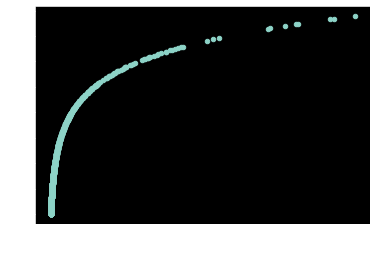

In [32]:
intensities.plot.scatter("spot_intensity", "norm_intensity_seurat")

In [33]:
intensities["spot_intensity"] = intensities["norm_intensity_seurat"]





## Data visualization in UMAP space

### UMAP based on molecule features

In [34]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(features_norm_df[mol_properties_cols])

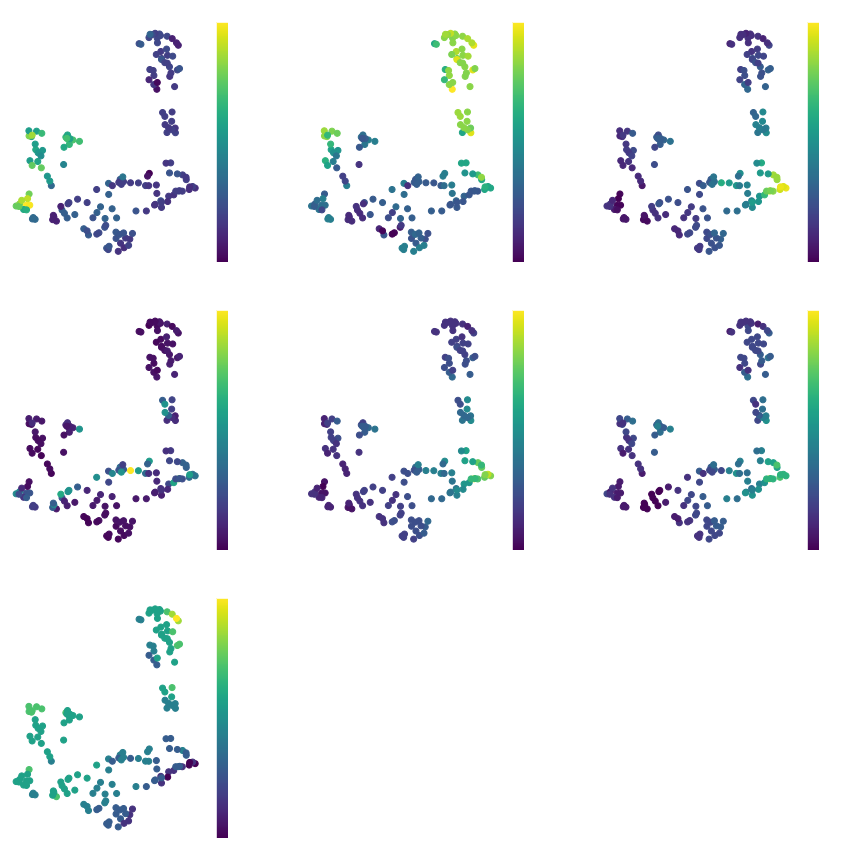

In [35]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = [axes[i,j] for i in range(num_cols) for j in range(num_rows)]
for i, ax in enumerate(axes):
    if i < len(mol_properties_cols):
        sc = ax.scatter(embedding[:, 0], embedding[:, 1], c = all_mol_features[mol_properties_cols[i]],
               # cmap = plt.cm.SOME_CM
               )
        plt.colorbar(sc, ax=ax)
        ax.set_title(mol_properties_cols[i])
    ax.axis('off')

### UMAP based on fingerprints


In [36]:
embedding = reducer.fit_transform(features_norm_df[fingerprints_cols])

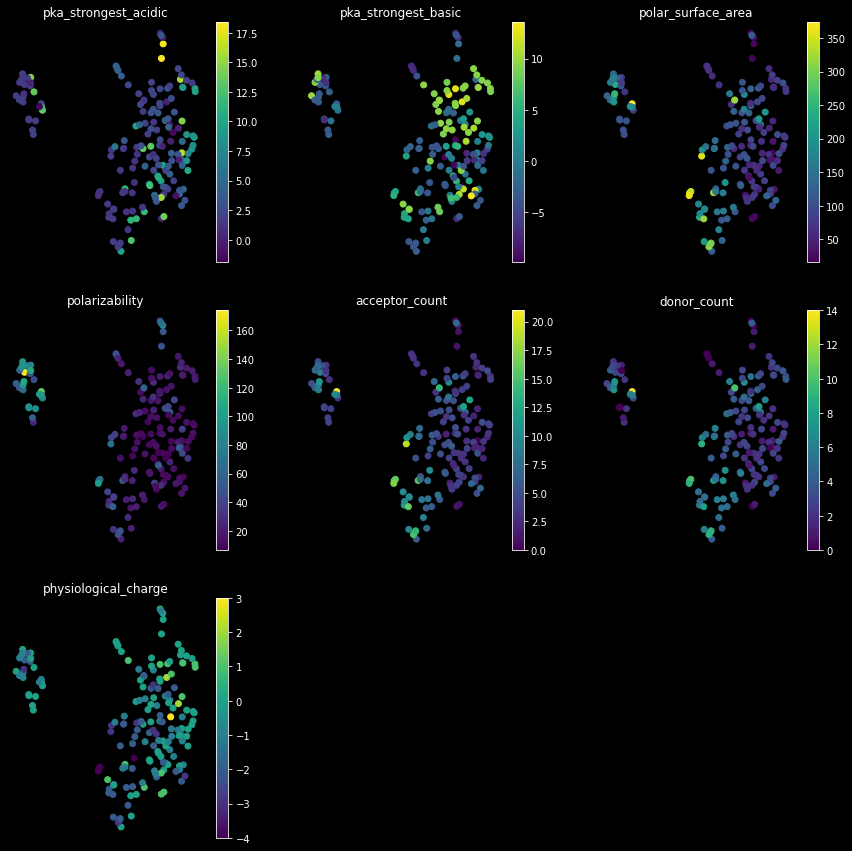

In [34]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = [axes[i,j] for i in range(num_cols) for j in range(num_rows)]
for i, ax in enumerate(axes):
    if i < len(mol_properties_cols):
        sc = ax.scatter(embedding[:, 0], embedding[:, 1], c = all_mol_features[mol_properties_cols[i]],
               # cmap = plt.cm.SOME_CM
               )
        plt.colorbar(sc, ax=ax)
        ax.set_title(mol_properties_cols[i])
    ax.axis('off')




### UMaps showing intensity per matrix
First, try to compute UMAP on all intensities (add adducts as binary features):

In [35]:
embedding = reducer.fit_transform(features_norm_df[fingerprints_cols])

/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [39]:
g = intensities.sort_values("norm_intensity_seurat", ascending=False).groupby(["name_short", "matrix", "polarity"], as_index=False)
max_intensities = g["norm_intensity_seurat"].max()



In [42]:
features_norm_df

,pka_strongest_acidic,pka_strongest_basic,polar_surface_area,polarizability,acceptor_count,donor_count,physiological_charge,1,8,13,...,1977,1991,1992,1995,2001,2004,2018,2034,2038,2044
2-Oxoglutaric acid,-0.163972,-2.326224,-0.148236,-0.968884,0.086129,-0.583358,-1.002374,-1.030037,-0.20787,-0.222911,...,-0.077152,-0.134433,-0.077152,-0.077152,-0.077152,-0.191859,-0.077152,-0.077152,-0.276465,-0.077152
3-Hydroxyanthranilic acid,-0.407505,0.665705,-0.299465,-0.690581,-0.269747,-0.071468,-0.248879,-1.030037,-0.20787,-0.222911,...,-0.077152,7.438638,-0.077152,-0.077152,-0.077152,-0.191859,-0.077152,-0.077152,-0.276465,-0.077152
3-Hydroxymethylglutaric acid,0.128244,-0.647539,-0.092631,-0.645270,0.086129,-0.071468,-1.002374,-1.030037,-0.20787,-0.222911,...,-0.077152,-0.134433,-0.077152,-0.077152,-0.077152,-0.191859,-0.077152,-0.077152,-0.276465,-0.077152
3-Phosphoglyceric acid,-0.662814,-0.925358,0.357884,-0.806622,0.383911,0.358963,-1.710475,0.970839,-0.20787,-0.222911,...,-0.077152,-0.134433,-0.077152,-0.077152,-0.077152,-0.191859,-0.077152,-0.077152,-0.276465,-0.077152
"4,5-Dihydroorotic acid",0.019645,-1.927337,-0.081056,-0.834185,-0.269747,-0.071468,-0.248879,-1.030037,-0.20787,-0.222911,...,-0.077152,-0.134433,-0.077152,-0.077152,-0.077152,-0.191859,-0.077152,-0.077152,-0.276465,-0.077152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xanthine,1.005763,-0.160674,-0.235910,-0.889643,-0.710783,-0.071468,0.580483,-1.030037,-0.20787,-0.222911,...,-0.077152,-0.134433,-0.077152,-0.077152,-0.077152,5.212165,-0.077152,-0.077152,-0.276465,-0.077152
alpha-tocopherol,1.432633,-1.093019,-1.902618,1.144373,-1.288408,-1.230080,0.580483,0.970839,-0.20787,-0.222911,...,-0.077152,-0.134433,-0.077152,-0.077152,-0.077152,-0.191859,-0.077152,-0.077152,-0.276465,-0.077152
cis-Aconitic acid,-0.346466,-0.030747,0.181604,-0.693077,0.383911,-0.071468,-1.710475,-1.030037,-0.20787,-0.222911,...,-0.077152,-0.134433,-0.077152,-0.077152,-0.077152,-0.191859,-0.077152,-0.077152,-0.276465,-0.077152
gamma-Aminobutyric acid,0.338727,1.316108,-0.743225,-1.230657,-0.710783,-0.583358,0.580483,-1.030037,-0.20787,-0.222911,...,-0.077152,-0.134433,-0.077152,-0.077152,-0.077152,-0.191859,-0.077152,-0.077152,-0.276465,-0.077152


In [36]:
num_rows = 5
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = [axes[i,j] for i in range(num_cols) for j in range(num_rows)]

for i, ((matrix, polarity), rows) in enumerate(max_intensities.groupby(['matrix', 'polarity'])):
    pd.merge(how="right", right_index=True, left_on="name_short")
    sc = axes[i].scatter(embedding[:, 0], embedding[:, 1], c = rows.loc[features_norm_df.index, "norm_intensity_seurat"],
               # cmap = plt.cm.SOME_CM
               )
    plt.colorbar(sc, ax=axes[i])
    axes[i].set_title(mol_properties_cols[i])
    axes[i].axis('off')


## Create train/val split

First, binarize the molecule features:

/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_83085/2825803642.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  features_norm_df[mol_properties_cols].hist(ax=ax)


array([[<AxesSubplot:title={'center':'pka_strongest_acidic'}>,
        <AxesSubplot:title={'center':'pka_strongest_basic'}>,
        <AxesSubplot:title={'center':'polar_surface_area'}>],
       [<AxesSubplot:title={'center':'polarizability'}>,
        <AxesSubplot:title={'center':'acceptor_count'}>,
        <AxesSubplot:title={'center':'donor_count'}>],
       [<AxesSubplot:title={'center':'physiological_charge'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

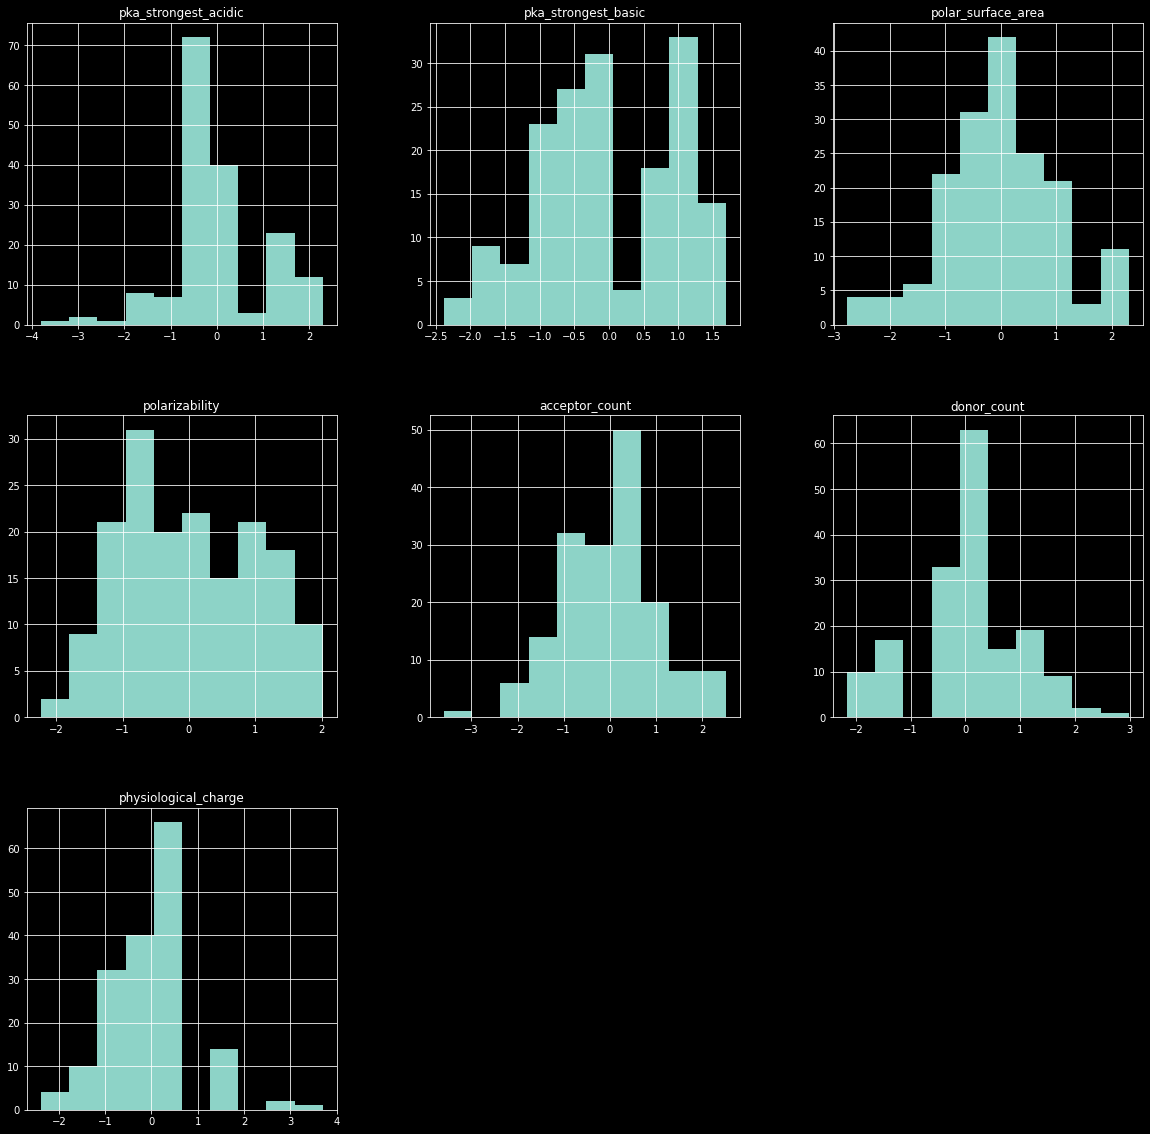

In [37]:
fig = plt.figure(figsize = (20,20))
ax = fig.gca()
features_norm_df[mol_properties_cols].hist(ax=ax)




Since not all the bins have enough datapoints, use quantiles to define the size of the bins:

In [38]:
# We only select only some features, otherwise there are not enough data in each of the splits:
# selected_stratification_features = [
#     "pka_strongest_basic",̊
#     "polar_surface_area",
#     "polarizability"
# ]
selected_stratification_features = mol_properties_cols

digitized_mol_properties = pd.DataFrame(index=features_norm_df.index)
for col in selected_stratification_features:
    digitized_mol_properties[col] = pd.qcut(features_norm_df[col], q=2, labels=[1, 2])

# digitized_mol_properties.value_counts()
# digitized_mol_properties


Now let's get the product of all the classes used for stratification:

In [39]:
intensities.columns


Index(['Matrix short', 'Polarity', 'adduct', 'name_short', 'detected',
       'spot_intensity', 'adduct_+Cl', 'adduct_+H', 'adduct_+K', 'adduct_+Na',
       'adduct_-H', 'adduct_[M]+', 'adduct_[M]-', 'norm_intensity',
       'norm_intensity_seurat'],
      dtype='object')

In [40]:
# First, remove adduct information from the intensity dataframe:
matrix_pol_df = intensities.drop(columns=['adduct', 'detected',
       'spot_intensity']).drop_duplicates().set_index('name_short', )

strat_feat = pd.merge(matrix_pol_df, digitized_mol_properties, how="left", left_index=True,
         right_index=True)
strat_feat.value_counts()

strat_feat['combined'] = strat_feat.astype(str).sum(axis=1).astype('category')

In [41]:
digitized_mol_properties['combined'] = digitized_mol_properties.astype(str).sum(axis=1).astype('category')

# digitized_mol_properties['combined'].value_counts()
